In [1]:
#import MEDYANSimRunner
using MEDYAN
using MEDYANVis
using StaticArrays
using LinearAlgebra
using Random
using Setfield
using OrderedCollections: OrderedDict
using SmallZarrGroups
using CairoMakie

Precompiling MEDYAN
  ✓ MEDYAN
  1 dependency successfully precompiled in 8 seconds. 115 already precompiled.
Precompiling MEDYANVis
  ✓ MEDYANVis
  1 dependency successfully precompiled in 5 seconds. 182 already precompiled.
Precompiling IntervalArithmeticForwardDiffExt
  ✓ IntervalArithmetic → IntervalArithmeticForwardDiffExt
  1 dependency successfully precompiled in 1 seconds. 25 already precompiled.


In [16]:
"Simulation cube length in 500 nm segments."
const L = 4

"Number of steps to take."
const NSTEPS = 1000

jobs = ["1", "2", "3",]

"""
Return the header_dict and context.
"""
function setup(job::String; kwargs...)
    agentnames = MEDYAN.AgentNames(
        diffusingspeciesnames= [:a,:cl,:m],
        filamentnames= [(:actin,[
                                :plusend,
                                :minusend,
                                :middle,
                                :bound,
                            ]),
        ],
        link_2mon_names= [
            :motor,
            :crosslinker,
        ]
    )
    grid = CubicGrid((L,L,L),500.0)
    monomerspacing = MEDYAN.ACTIN_FIL_PARAMS.spacing
    begin
        s= MEDYAN.SysDef(agentnames)

        add_diffusion_coeff!(s, :a, 20E6)
        add_diffusion_coeff!(s, :cl, 2.0E6)
        add_diffusion_coeff!(s, :m, 0.2E6)

        add_filament_params!(s, 
            :actin,
            MEDYAN.ACTIN_FIL_PARAMS,
        )

        add_link_2mon!(s,
            :motor,
            Link2MonState((numHeads=20,),(L0=NaN,)),
            MEDYAN.DistanceRestraintMechParams(k=55.0),
        )
        
        add_link_2mon!(s,
            :crosslinker,
            Link2MonState((;),(L0=NaN,)),
            MEDYAN.DistanceRestraintMechParams(k=8.0),
        )
        
        #plus end polymerization
        addfilamentend_reaction!(s, :actin, :pp, false,
            [:plusend]=>[:middle,:plusend], monomerspacing,
            "diffusing.a -->", 0.154*500^3, 1,
        )
        #plus end depolymerization
        addfilamentend_reaction!(s, :actin, :dpp, false,
            [:middle,:plusend]=>[:plusend], 0.0,
            "--> diffusing.a", 1.4, 0,
        )

        #minus end polymerization
        addfilamentend_reaction!(s, :actin, :mp, true,
            [:minusend]=>[:minusend,:middle], monomerspacing,
            "diffusing.a -->", 0.0173*500^3, 1,
        )
        #minus end depolymerization
        addfilamentend_reaction!(s, :actin, :dmp, true,
            [:minusend,:middle]=>[:minusend], 0.0,
            "--> diffusing.a", 0.8, 0,
        )

        motorstepsize = 10

        #motor binding
        site = MEDYAN.Decimated2MonSiteMinAngleRange(
            s.filament.actin,
            s.filament.actin,
            motorstepsize,
            motorstepsize,
            s.state.actin.middle,
            s.state.actin.middle,
            175.0,
            225.0,
            cos(5*π/180),
        )
        add_decimated_2mon_site!(s,:motorbinding,site)
        bindcallback = MEDYAN.SimpleMotorBindCallback(
            s.decimated_2mon_site.motorbinding.id,
            s.link_2mon.motor,
            30, #max number of heads
            15, #min number of heads
            s.state.actin.bound,
            [s.diffusing.m=>-1],
        )
        addreactioncallback!(
            s,
            "decimated_2mon_site.motorbinding + diffusing.m",
            0.2*22*500^3/2,
            1,
            bindcallback,
        )

        #motor unbinding
        site = MEDYAN.Link2MonSiteMotorCatch()
        addunbindinglink_2mon_site!(s, 
            :motor, :unbinding, site,
            :actin, :middle, :actin, :middle,
            "--> diffusing.m", 1.0, 0, 
        )

        #motor stepping
        onrate = 0.2
        offrate = 1.7
        dutyratio = onrate/(onrate+offrate)
        site1 = MEDYAN.Link2MonSiteMotorStall(
            fs = 90.0,
            k0 = 6.0/(108/4)*((1 - dutyratio) / dutyratio) * onrate,
            isminusend = true,
        )
        site2 = @set site1.isminusend = false
        add_link_2mon_site!(s,:motor,:motorstepminus,site1)
        add_link_2mon_site!(s,:motor,:motorstepplus,site2)
        stepcallback1 = MEDYAN.SimpleMotorStepCallback(
            lsid = s.link_2mon_site.motor.motorstepminus.id,
            ltid = s.link_2mon.motor,
            unboundstate = s.state.actin.middle,
            boundstate = s.state.actin.bound,
            stepsize = motorstepsize,
        )
        stepcallback2 = @set stepcallback1.lsid = s.link_2mon_site.motor.motorstepplus.id
        addreactioncallback!(
            s,
            "link_2mon_site.motor.motorstepminus",
            1.0,
            0,
            stepcallback1,
        )
        addreactioncallback!(
            s,
            "link_2mon_site.motor.motorstepplus",
            1.0,
            0,
            stepcallback2,
        )

        #crosslinker binding site
        site = MEDYAN.Decimated2MonSiteMinAngleRange(
            s.filament.actin,
            s.filament.actin,
            10,
            10,
            s.state.actin.middle,
            s.state.actin.middle,
            30.0,
            40.0,
            cos(5*π/180)
        )
        add_decimated_2mon_site!(s,:crosslinkbinding,site)
        sitecallback = MEDYAN.SimpleCrosslinkBindCallback(
            s.decimated_2mon_site.crosslinkbinding.id,
            s.link_2mon.crosslinker,
            s.state.actin.bound,
            [s.diffusing.cl=>-1],
        )
        addreactioncallback!(s,
            "decimated_2mon_site.crosslinkbinding + diffusing.cl",
            0.01*500^3/2,
            1,
            sitecallback,
        )

        #crosslinker unbinding
        site = MEDYAN.Link2MonSiteSlipBond(f0 = inv(0.24*MEDYAN.default_β) , k0 = 0.3)
        addunbindinglink_2mon_site!(s, 
            :crosslinker, :unbinding, site,
            :actin, :middle, :actin, :middle,
            "--> diffusing.cl", 1.0, 0, 
        )
    end
    begin
        NMonomers= 40
        monomerstates= zeros(UInt8,NMonomers)
        monomerstates[1:end] .= s.state.actin.middle
        monomerstates[1] = s.state.actin.minusend
        monomerstates[end] = s.state.actin.plusend
    end
    begin
        c= MEDYAN.Context(s,grid;
            g_tol=1.0,
            max_cylinder_force = 1000.0,
            maxstep = 0.7,
        )
        set_mechboundary!(c, MEDYAN.boundary_box(grid; stiffness=100.0))
        adddiffusingcount_rand!(c, s.diffusing.a, 625*L^3)
        adddiffusingcount_rand!(c, s.diffusing.cl, 63*L^3)
        adddiffusingcount_rand!(c, s.diffusing.m, 6*L^3)
        for i in 1:(7*L^3)
            newfilament_rand!(c::MEDYAN.Context, monomerstates)
            MEDYAN.minimize_energy!(c)
        end
    end
    header = OrderedDict([
        "medyan"=>MEDYAN.header(c),
    ])
    return header, c, s
end

"""
Save the context into a group
"""
function save(step::Int, c::MEDYAN.Context; kwargs...)::ZGroup
    group = ZGroup()
    group["medyan"] = MEDYAN.snapshot(c;
        filament_position_scale=5,
        membrane_position_scale=5,
    )
    group
end

"""
Load the context from a group
"""
function load(step::Int, group::ZGroup, c; kwargs...)
    MEDYAN.load_snapshot!(c, group["medyan"]::ZGroup)
    c
end

function done(step::Int, c)
    step ≥ NSTEPS, NSTEPS
end

"""
Move the simulation forward one second in time.
"""
function loop(step::Int, c; kwargs...)
    for j in 1:20
        MEDYAN.run_chemistry!(c,0.05)
        MEDYAN.minimize_energy!(c)
    end
    c
end

loop

In [17]:
vis = Visualizer()
setvisible!(vis["/Grid"], false)
setvisible!(vis["/Axes"], false)
setvisible!(vis["/Background"], false)

[ Info: Listening on: 127.0.0.1:8701, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8701


MeshCat Visualizer with path /Background at http://127.0.0.1:8701

In [49]:
"""
Creates an array of all monomer positions.
"""
function calc_rmon(c::MEDYAN.Context)
    rmon = SVector{3, Float64}[]
    for fil_id in filtype_fil_ids(c, 1)
        for mon_id in eachindex(fil_mon_states(c, 1, fil_id))
            name = MonomerName(1, fil_id, mon_id)
            push!(rmon,mon_position(c,name))
        end
    end
    return rmon
end

"""
Calculates the center of mass velocity of the network.
"""
function vel_com_cell(c,drmon,rmon_old)
    n_cell = MArray{Tuple{L^3},Int64}(zeros(L^3))
    dra_x_cell = MArray{Tuple{L^3},Float64}(zeros(L^3))
    dra_y_cell = MArray{Tuple{L^3},Float64}(zeros(L^3))
    dra_z_cell = MArray{Tuple{L^3},Float64}(zeros(L^3))
    #loop over all monomers accumulate array values, sort into cells using rmon_old
    for i in 1:size(rmon_old,1)
        cid = MEDYAN.grididat(c.grid, view(rmon_old,i)[1])
        n_cell[cid] += 1
        dra_x_cell[cid] += view(drmon,i)[1][1]
        dra_y_cell[cid] += view(drmon,i)[1][2]
        dra_z_cell[cid] += view(drmon,i)[1][3]  
    end
    va_x_cell = dra_x_cell./n_cell
    va_y_cell = dra_y_cell./n_cell
    va_z_cell = dra_z_cell./n_cell
    return va_x_cell,va_y_cell,va_z_cell
end

"""
Calculates the porosity field.
"""
function calc_por_cell(c,rmon_old,lcell)
    #estimate actin monomer volume by assume it is a sphere with radius 3.5 nm
    actin_rad = 3.5
    actin_vol = (4/3)*π*(actin_rad^3)
    por_cell = MArray{Tuple{L^3},Float64}(zeros(L^3))
    #loop over all monomers accumulate array values, sort into cells using rmon_old
    for i in 1:size(rmon_old,1)
        cid = MEDYAN.grididat(c.grid, view(rmon_old,i)[1])
        por_cell[cid] += 1
    end
    por_cell *= actin_vol/(lcell^3)
    return por_cell
end

"""
Calculates the hydrolic permiability from porosity, using Gebart's formula.
"""
function calc_hydro_perm_cell(por_cell)
    #filament diameter in nm
    d = 7.0
    #fitting parameters
    ϕc = 0.0743 
    C1 = 0.491
    C2 = 2.31
    perm_cell = map(x -> (d^2)*C1*(sqrt((1-ϕc)/(1-x))-1)^C2,por_cell)
    #perm_cell = map(x -> (sqrt((1-ϕc)/(1-x))-1)^C2,por_cell)
    return perm_cell
end

calc_hydro_perm_cell

In [50]:
#set up system and run
nsec = 1
header,c,s = setup(jobs[1])
lcell = 500

for i in 1:nsec
    for j in 1:20
        MEDYAN.run_chemistry!(c,0.05)
        
        #get n-1-th minimized state
        rmon_old = calc_rmon(c)
        
        #get n-th minimized state
        MEDYAN.minimize_energy!(c)
        rmon_new = calc_rmon(c)
        drmon = rmon_new .- rmon_old
        
        #calculate the network velocity
        va_x_cell, va_y_cell, va_z_cell = vel_com_cell(c,drmon,rmon_old)
        #calculate the porosity field
        por_cell = calc_por_cell(c,rmon_old,lcell)
        #calculate the hydrolic permiability tensor element
        perm_cell = calc_hydro_perm_cell(por_cell)
        println(perm_cell)
        
        draw_context!(vis, c, s)
        sleep(0.02)
    end
end

LoadError: DomainError with -0.03764155091420773:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

In [52]:
-0.03764155091420773^2.31

-0.0005126157501815978

In [ ]:
MArray{{L^3},Int64}(zeros(L^3))


In [ ]:
mat = MArray{Tuple{3,3},Float64}(zeros(3,3))
println(mat)
mat[3] = 1
println(mat)

In [ ]:
function hydro_setup()
    

#function cell_fil_com()
    

In [ ]:
x = [2,4,6]
y = [1,2,3]
println(x./y)
a = [3,6,9]
b = [1,2,3]
println(a./b)
mat = [x./y,a./b]
mat[2]

In [ ]:
mat = [1,2,3,4,5]
sum(mat)

In [ ]:
@SArray m = SArray{Tuple{L,L,L},Int64}
m[3] = 1

In [ ]:
mat = rand(3,3)
println(mat)
mat[4]

In [ ]:
"""
Function maps from serial cell index to 3 cartesian index triple (nx,ny,nz).
"""
function serial_to_cart(c,cid)
    
end

In [ ]:
println(c.grid.n[1])


In [ ]:
println(rmon_old)

In [ ]:
println(SMatrix{c.grid})

In [ ]:
#grid = CubicGrid((L,L,L),500.0)
MEDYAN.grididat(c.grid, [-10000,1000,500.0])

In [ ]:
println(rmon_old)

In [ ]:
MEDYAN.mon_position(c,MonomerName(1,1,3))

In [ ]:
fil_mon_states(c, 1, 1)

In [ ]:
#set up system and run
nsec = 1
header,c,s = setup(jobs[1])

for i in 1:nsec
    for j in 1:100
        MEDYAN.run_chemistry!(c,0.01)
        MEDYAN.minimize_energy!(c)
        draw_context!(vis, c, s)
        println(fil_node_positions(c,1,3)) 
        sleep(0.02)
    end
end

In [ ]:
s.filament

In [ ]:

for i in 1:1000
    run_chemistry!(c, 0.01)
    MEDYANVis.drawdiffusing!(vis["diffusing"], c.grid, c.chemistryengine, s; size = 0.8)
    sleep(0.02)
end

In [ ]:
typeof(view(done(1,c),1))

In [ ]:
#set up system and run
nsec = 1
header,c,s = setup(jobs[1])
#rmon_old = SVector{3, Float64}[]
#rmon_new = SVector{3, Float64}[]
drmon = rmon_new .-rmon_old

#nmon_cell = 
#drcom_cell =

for i in 1:nsec
    for j in 1:20
        MEDYAN.run_chemistry!(c,0.05)
        rmon_old = calc_rmon(c)
        MEDYAN.minimize_energy!(c)
        rmon_new = calc_rmon(c)
        draw_context!(vis, c, s)
        sleep(0.02)
    end
end

In [ ]:
"""
Creates an array of all monomer positions.
"""
function calc_rmon(c::MEDYAN.Context)
    rmon = SVector{3, Float64}[]
    for fil_id in filtype_fil_ids(c, 1)
        for mon_id in eachindex(fil_mon_states(c, 1, fil_id))
            name = MonomerName(1, fil_id, mon_id)
            push!(rmon,mon_position(c,name))
        end
    end
    return rmon
end

In [ ]:
MEDYAN.grididat(c.grid, [-10000,1000,500.0])

In [ ]:
"""
Creates an array of all monomer positions.
"""
function calc_rmon(c::MEDYAN.Context)
    rmon = SVector{3, Float64}[]
    for fil_id in filtype_fil_ids(c, 1)
        for mon_id in eachindex(fil_mon_states(c, 1, fil_id))
            name = MonomerName(1, fil_id, mon_id)
            push!(rmon,mon_position(c,name))
        end
    end
    return rmon
end

LinRange{Float64}(0.5, 0.999, 1000)
0.04655671006052285


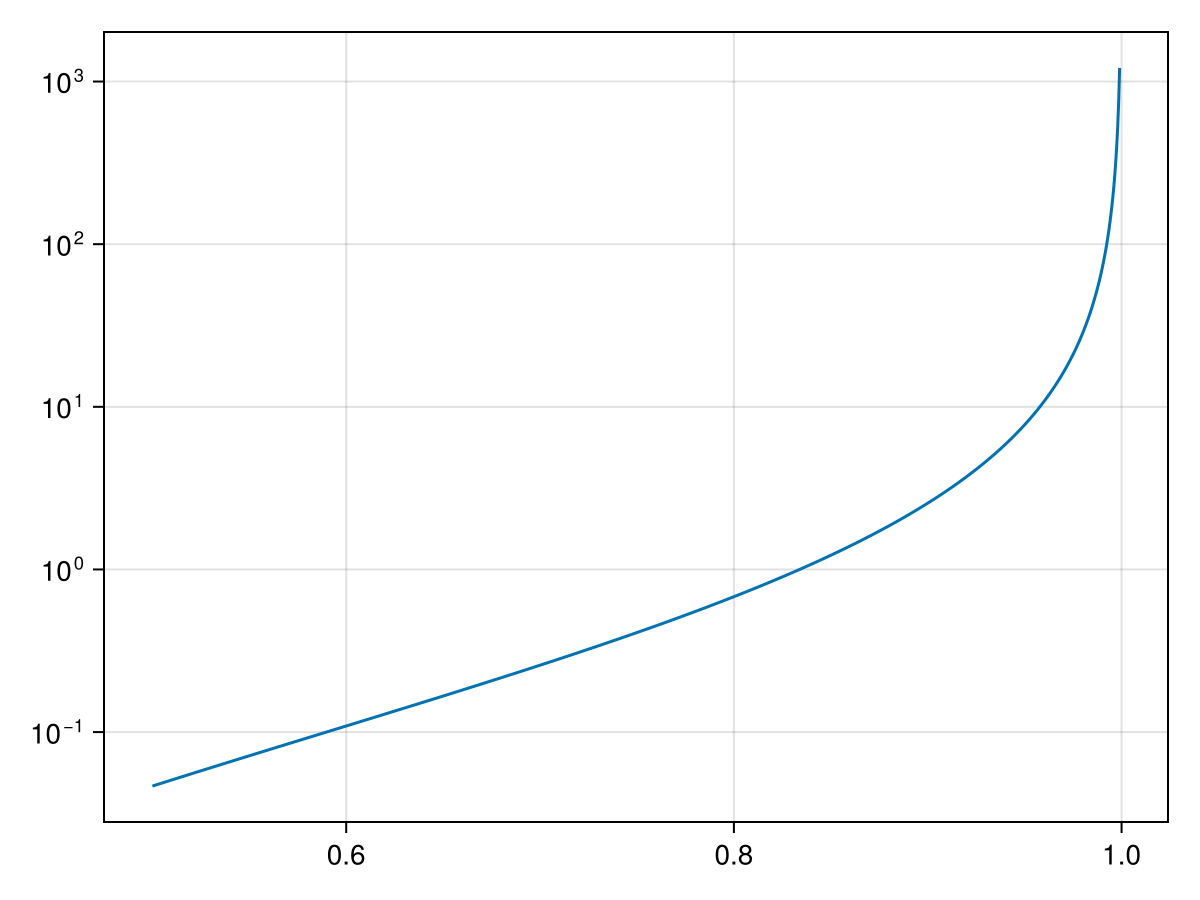

In [8]:
d = 7.0
arr = LinRange(0.5,0.999,1000)
println(arr)
hparr = calc_hydro_perm_cell(arr)/(d^2)
println(hparr[1])

f = Figure()
Axis(f[1, 1],yscale = log10)
lines!(arr, hparr)
f